In [1]:
# For basic operations
import pandas as pd
import numpy as np
import datetime
from datetime import date 
from datetime import datetime
import scipy.stats
from scipy import stats
import time
from termcolor import colored

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data transformation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler, LabelEncoder, OneHotEncoder

# For addressing imbalance
!pip install imblearn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from numpy import arange

# For model building
from prince import FAMD
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mean_squared_error, confusion_matrix, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve

# 1. Import data

In [2]:
churn_df = pd.read_csv('~/CustomerChurn.csv', sep=';')

# 2. Data cleaning

### 2.1. Check for missing values

In [3]:
# Create a function to calculate the percentage of null values in the dataframe
def check_missing_values(df, df_name):
    print(f'Percentage of null values in {df_name}')
    print('-------------------------------------------------------')
    for i, col in df.items():
        count_null = col.isnull()
        percentage_null = round(count_null.sum() * 100.0 / np.shape(df)[0],2)
        print(f'Percentage of null values in column {i} = {percentage_null}%')

In [4]:
# Apply the function
check_missing_values(churn_df, "Churn Data")

Percentage of null values in Churn Data
-------------------------------------------------------
Percentage of null values in column CustomerID = 0.0%
Percentage of null values in column Count = 0.0%
Percentage of null values in column Country = 0.0%
Percentage of null values in column State = 0.0%
Percentage of null values in column City = 0.0%
Percentage of null values in column Zip Code = 0.0%
Percentage of null values in column Lat Long = 0.0%
Percentage of null values in column Latitude = 0.0%
Percentage of null values in column Longitude = 0.0%
Percentage of null values in column Gender = 0.0%
Percentage of null values in column Senior Citizen = 0.0%
Percentage of null values in column Partner = 0.0%
Percentage of null values in column Dependents = 0.0%
Percentage of null values in column Tenure Months = 0.0%
Percentage of null values in column Phone Service = 0.0%
Percentage of null values in column Multiple Lines = 0.0%
Percentage of null values in column Internet Service = 0.0%

In [5]:
# Replace missing Churn Reason to 'Not churn', because this field is blank when Churn Label = 'No'
churn_df['Churn Reason'] = churn_df['Churn Reason'].replace(np.nan, 'Not churn')

### 2.2. Check for blank space/white space

In [6]:
# Create a function to calculate the percentage of blank space/white space in the dataframe
def check_white_space(df, df_name):
    print(f'Percentage of white space in {df_name}')
    print('-------------------------------------------------------')
    for i, col in df.items():
        count_white_space = df[i].astype(str).str.fullmatch(r'^\s*$')
        percentage_white_space = round(count_white_space.sum() * 100.0 / np.shape(df)[0],2)
        print(f'Percentage of white space in column {i} = {percentage_white_space}%')

In [7]:
# Apply the function
check_white_space(churn_df, "Churn Data")

Percentage of white space in Churn Data
-------------------------------------------------------
Percentage of white space in column CustomerID = 0.0%
Percentage of white space in column Count = 0.0%
Percentage of white space in column Country = 0.0%
Percentage of white space in column State = 0.0%
Percentage of white space in column City = 0.0%
Percentage of white space in column Zip Code = 0.0%
Percentage of white space in column Lat Long = 0.0%
Percentage of white space in column Latitude = 0.0%
Percentage of white space in column Longitude = 0.0%
Percentage of white space in column Gender = 0.0%
Percentage of white space in column Senior Citizen = 0.0%
Percentage of white space in column Partner = 0.0%
Percentage of white space in column Dependents = 0.0%
Percentage of white space in column Tenure Months = 0.0%
Percentage of white space in column Phone Service = 0.0%
Percentage of white space in column Multiple Lines = 0.0%
Percentage of white space in column Internet Service = 0.0%

In [8]:
# Drop rows with missing Total Charges because it only comprises 0.16% of total samples
churn_df = churn_df.replace(r'^\s*$', np.nan, regex=True)
churn_df = churn_df.dropna()

### 2.3. Check data types

In [9]:
churn_df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Reason          object
dtype: object

In [10]:
# Change 'Total Charges' from object to float64
churn_df['Total Charges'] = churn_df['Total Charges'].astype('float')

# 3. Exploratory Data Analysis

In [11]:
DatasetSize = churn_df.shape[0]
ChurnCount = len(churn_df[churn_df['Churn Label']=='Yes'])
RetainedCount = len(churn_df[churn_df['Churn Label']=='No'])

print('Churn dataset')
print(f'There are {DatasetSize} records in the dataset with {ChurnCount} churn customers and {RetainedCount} retained customers')

Churn dataset
There are 7032 records in the dataset with 1869 churn customers and 5163 retained customers


In [12]:
def describe_dataset(df):
    col = []
    dtype = []
    value = []
    num_unique_value = []
    
    for i in df.columns:
        col.append(i)
        dtype.append(df[i].dtypes)
        value.append(df[i].unique())
        num_unique_value.append(df[i].nunique())
    
    return pd.DataFrame({'Feature': col, 'Data Type': dtype, 'Unique value': value, 'Number of unique value': num_unique_value})

In [13]:
describe_dataset(churn_df)

,Feature,Data Type,Unique value,Number of unique value
0,CustomerID,object,"[3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...",7032
1,Count,int64,[1],1
2,Country,object,[United States],1
3,State,object,[California],1
4,City,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
5,Zip Code,int64,"[90003, 90005, 90006, 90010, 90015, 90020, 900...",1652
6,Lat Long,object,"[33.964131, -118.272783, 34.059281, -118.30742...",1652
7,Latitude,float64,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",1652
8,Longitude,float64,"[-118.272783, -118.30742, -118.293953, -118.31...",1651
9,Gender,object,"[Male, Female]",2


### 3.1. Percentage of churn customers and number of churn customers by churn reasons

In [14]:
def count_churn_by_col(df, col):
    result_df = df.groupby([col], as_index=False).size().rename(columns={'size':'Total Customers'}).sort_values('Total Customers', ascending=False)
    
    # Count percentage of total and cumulative sum of each category
    pct_of_total = []
    for i, col in result_df['Total Customers'].items():
        pct = col/result_df['Total Customers'].sum()*100
        pct_of_total.append(pct)
    
    result_df['Total Customers Pct'] = pct_of_total
    result_df['Total Customers Pct CumSum'] = result_df['Total Customers Pct'].cumsum()
    
    return result_df

In [16]:
# Create a function to annotate pie charts
def define_pie_chart_autopct(values):
    def autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return autopct

In [17]:
def get_single_barplot(y_series, x_series, palette):
    bar_plot = sns.barplot(y=y_series, x=x_series, orient='h', palette=palette)
    bar_plot.set(xticks=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks(fontsize=10)
    return bar_plot

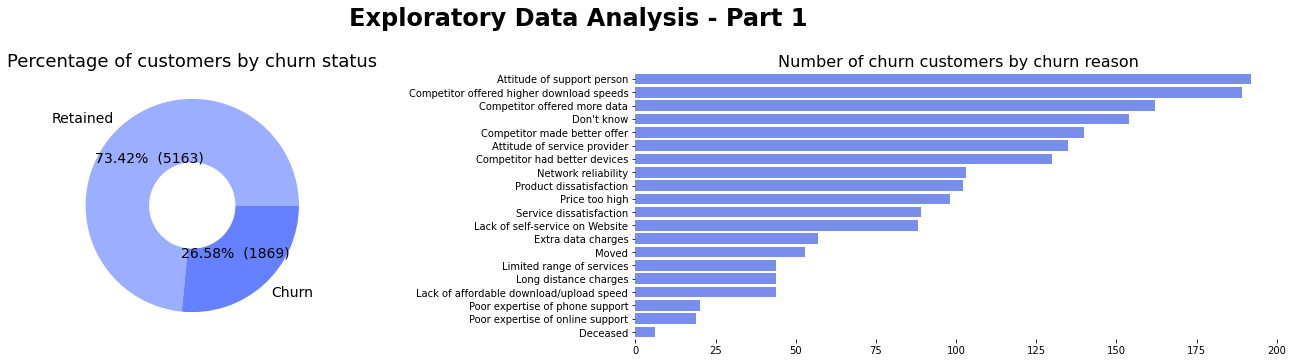

In [18]:
# Declare data to visualise
count_churn_df = churn_df.groupby(['Churn Label'], as_index=False).size()
churn_by_reason_df = count_churn_by_col(churn_df[churn_df['Churn Label']=='Yes'], 'Churn Reason')

# Declare chart colors
colors = ['#9CAEFF','#6581FF','#4AD8CE']

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle(f'Exploratory Data Analysis - Part 1', fontsize=24, y=1, fontweight='bold')

# Chart 1: Percentage of customers by churn label
plt.subplot(1,2,1)
plt.title(f'Percentage of customers by churn status',size=18) 
ax1_label = ['Retained','Churn']
ax1_pie_size = count_churn_df['size'].to_list() 
plt.pie(ax1_pie_size, labels=ax1_label, autopct=define_pie_chart_autopct(ax1_pie_size), textprops=dict(color="black",size=14), colors=colors)
plt.gcf().gca().add_artist(plt.Circle((0,0),0.4,color='white'))

# Chart 2: Number of churn by churn reason
plt.subplot(1,2,2)
plt.title(f'Number of churn customers by churn reason',size=16) 
sns.barplot(y=churn_by_reason_df['Churn Reason'], x=churn_by_reason_df['Total Customers'], orient='h', ax=ax2, color=colors[1])
sns.despine(left=True, bottom=True)
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
plt.show()

### 3.2. Customer demographics (Churn vs Retained)

In [19]:
def get_multiple_pie_charts(df, col_list):
    num_chart = len(col_list)
    subplot_col = 3
    subplot_row = int(num_chart*2/subplot_col)
    colors = ['#FCBA03','#6581FF','#4AD8CE','#E45BFF']

    fig, ax = plt.subplots(figsize = (17, int(4*subplot_row)))
    fig.suptitle(f'Exploratory Data Analysis - Part 2', fontsize=24, y=1, fontweight='bold')
    
    for i in list(range(0, num_chart)):
        plt.subplot(subplot_row, subplot_col, i+1)
        if i % 3 == 0:
            agg_df = df.groupby([col_list[i]], as_index=False).size()
            plt.title(f'All Customers by {col_list[i]}',size=16) 
        elif (i-2) % 3 == 0:
            agg_df = df[df['Churn Label']=='No'].groupby([col_list[i]], as_index=False).size()
            plt.title(f'Retained Customers by {col_list[i]}',size=16)   
        elif (i-1) % 3 == 0:
            agg_df = df[df['Churn Label']=='Yes'].groupby([col_list[i]], as_index=False).size()
            plt.title(f'Churn Customers by {col_list[i]}',size=16)   
    
        label = agg_df[col_list[i]].to_list()
        pie_size = agg_df['size'].to_list() 
        plt.pie(pie_size, labels=label, autopct=define_pie_chart_autopct(pie_size), textprops=dict(color="black",size=10), colors=colors)
        plt.gcf().gca().add_artist(plt.Circle((0,0),0.4,color='white'))
        plt.tight_layout()

In [20]:
# Generate a list to be an input for the visualisation
def get_col_list(col_list):
    result=[]
    for col in col_list:
        for i in range(0,3):
            result.append(col)
            i+=1
    return result

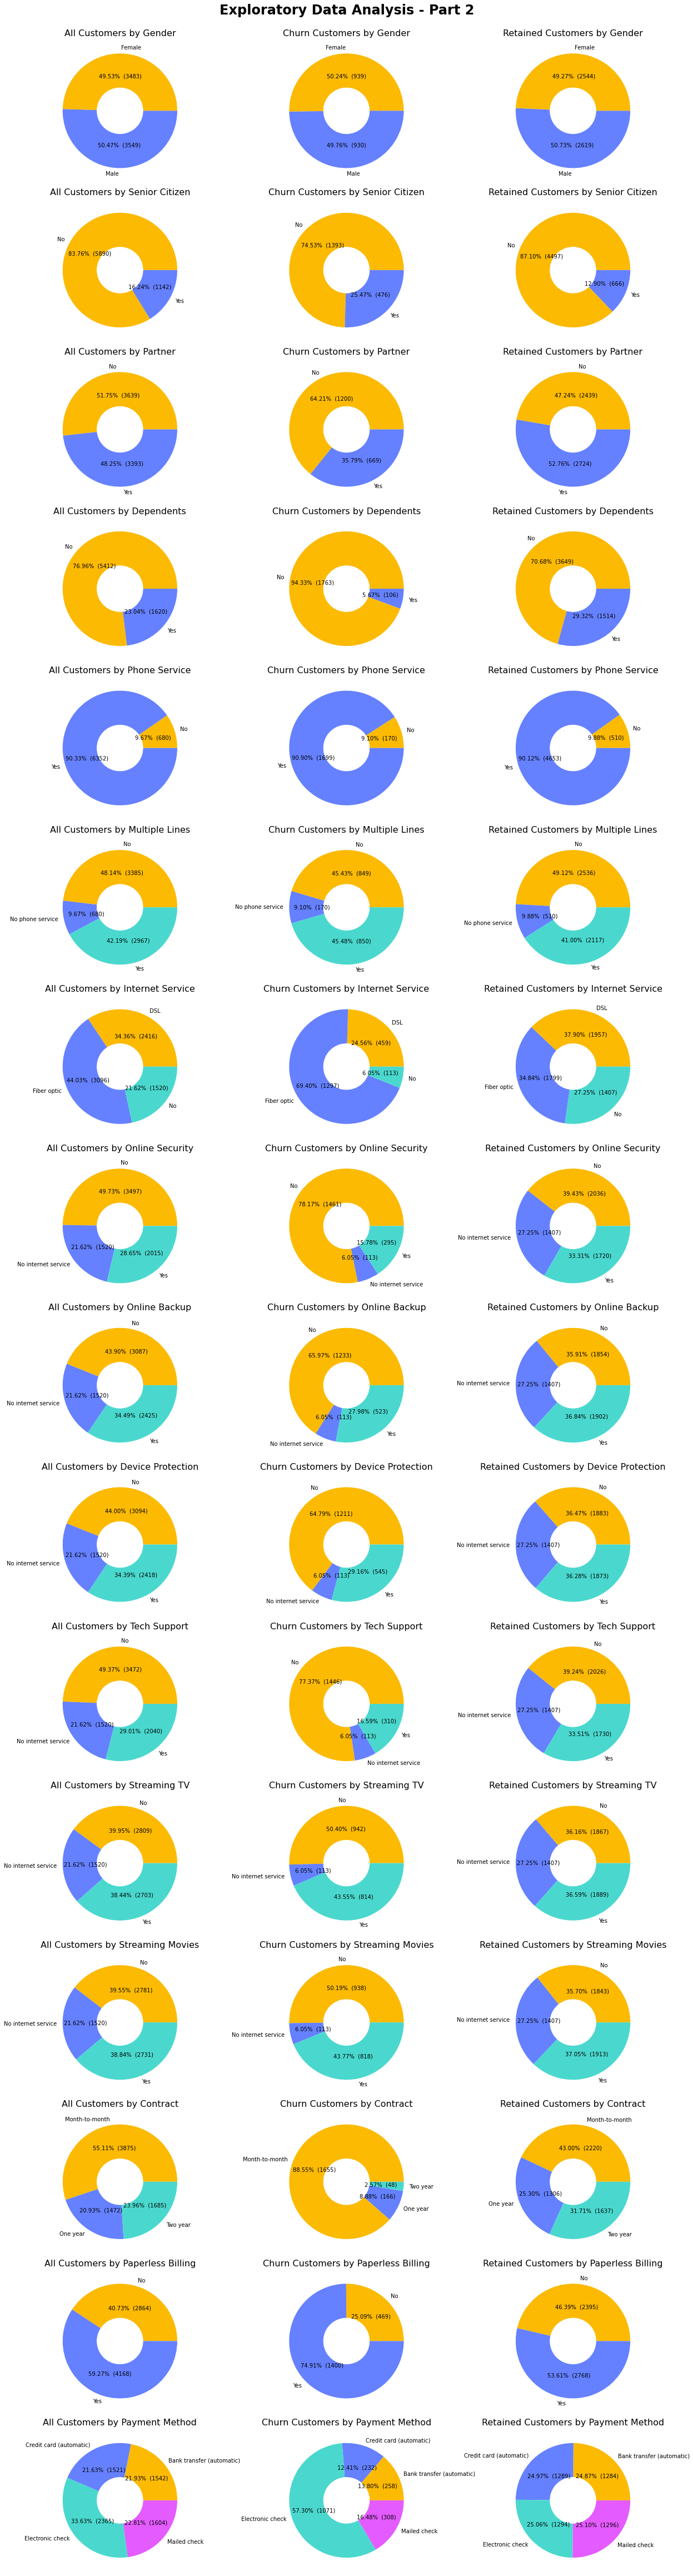

In [21]:
# Declare columns to visualise
pie_chart_col_reference=['Gender','Senior Citizen','Partner','Dependents','Phone Service',
               'Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection',
               'Tech Support','Streaming TV','Streaming Movies','Contract','Paperless Billing','Payment Method']

# Generate column list
pie_chart_col_list=get_col_list(pie_chart_col_reference)

# Get pie charts
get_multiple_pie_charts(churn_df, pie_chart_col_list)

In [22]:
def get_multiple_histplots(df, col_list):
    num_chart = len(col_list)
    subplot_col = 3
    subplot_row = int(num_chart/subplot_col)
    colors = ['#6581FF','#E45BFF','#4AD8CE']
    title_font_size = 20
    
    fig, ax = plt.subplots(nrows=subplot_row, ncols=subplot_col, figsize=(30,20))
    fig.suptitle(f'Exploratory Data Analysis - Part 3', fontsize=30, y=0.93, fontweight='bold')

    for i in list(range(0, num_chart)):
        plt.subplot(subplot_row, subplot_col, i+1)
        if i % 3 == 0:
            chart_df = df
            plt.title(f'All Customers by {histplot_col_list[i]}',size=title_font_size) 
            sns.histplot(data=chart_df, x=chart_df[histplot_col_list[i]], color=colors[0])
        elif (i-1) % 3 == 0:
            chart_df = df[df['Churn Label']=='Yes']
            plt.title(f'Churn Customers by {histplot_col_list[i]}',size=title_font_size)   
            sns.histplot(data=chart_df, x=chart_df[histplot_col_list[i]], color=colors[1])
        elif (i-2) % 3 == 0:
            chart_df = df[df['Churn Label']=='No']
            plt.title(f'Retained Customers by {histplot_col_list[i]}',size=title_font_size)  
            sns.histplot(data=chart_df, x=chart_df[histplot_col_list[i]], color=colors[2])

        plt.ylim(0, 1800)

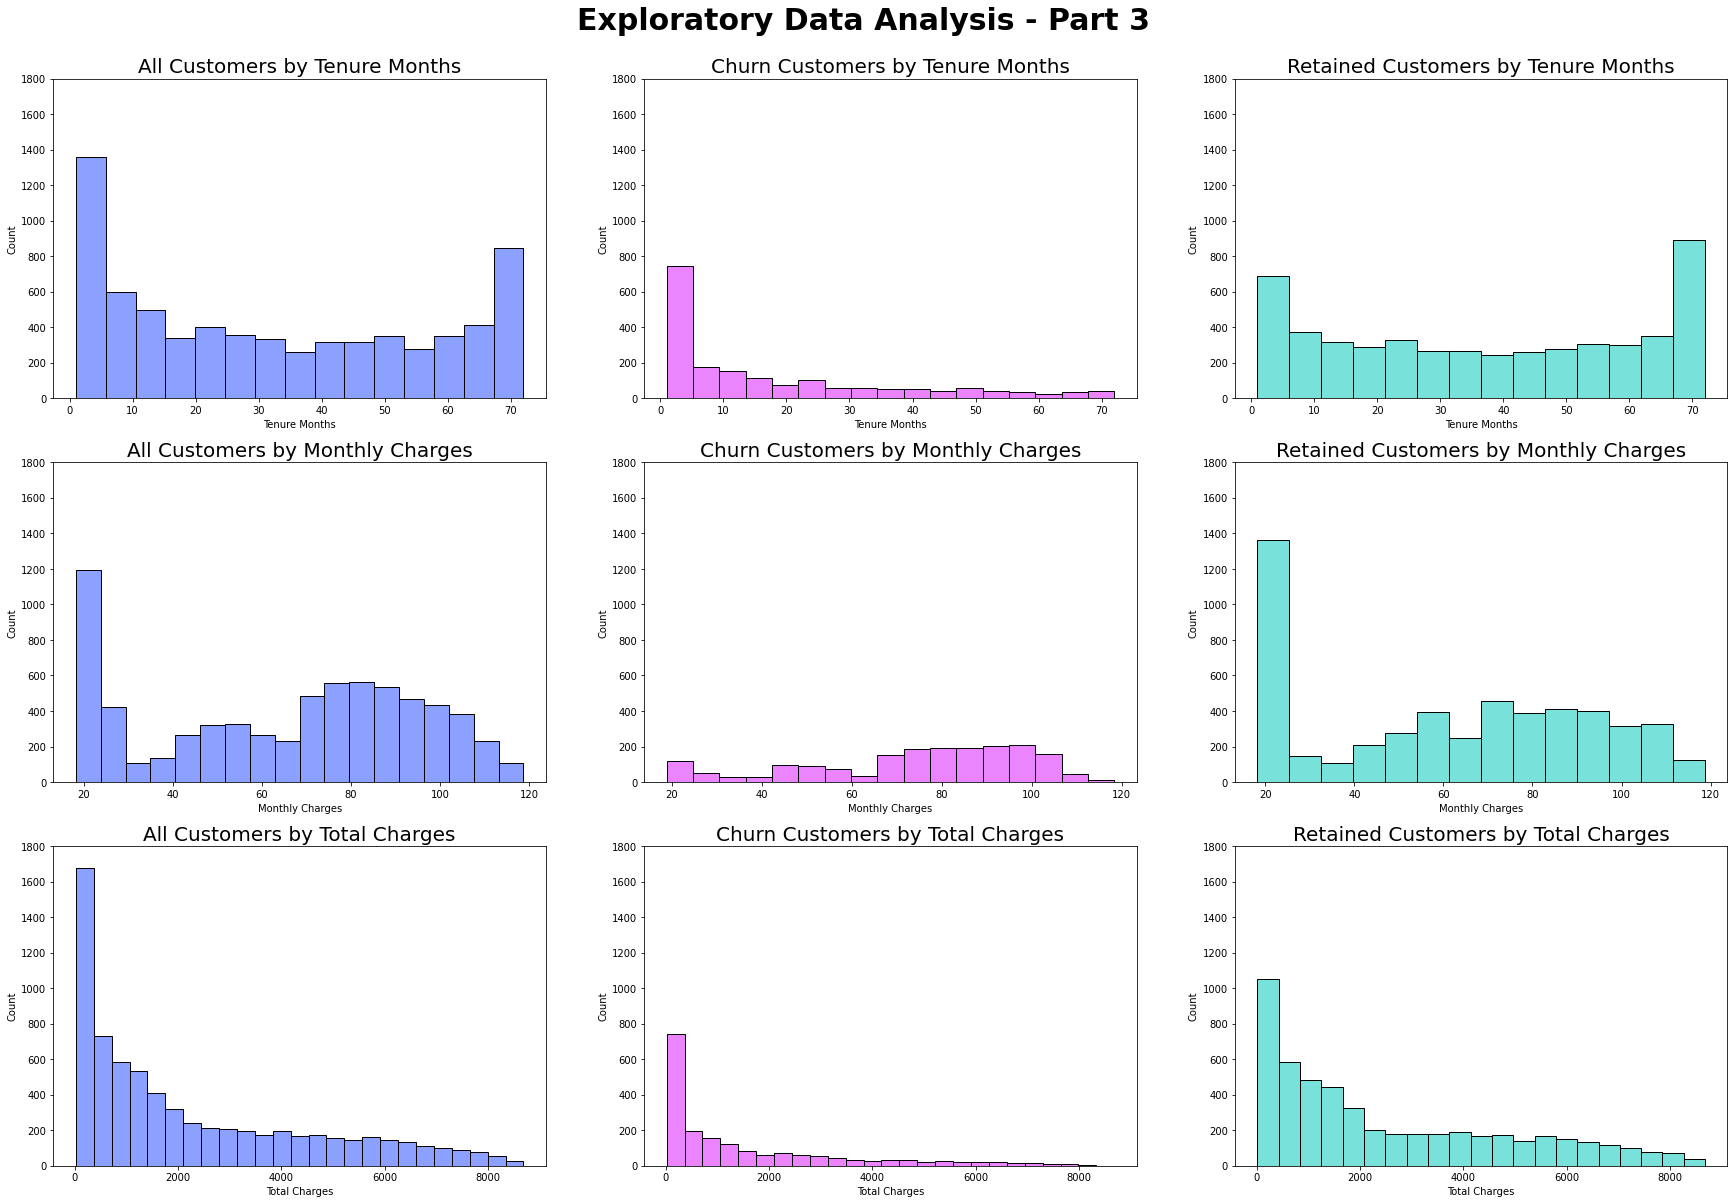

In [23]:
# Declare columns to visualise
histplot_col_reference = ['Tenure Months', 'Monthly Charges', 'Total Charges']

# Generate column list
histplot_col_list = get_col_list(histplot_col_reference)

# Get histplots
get_multiple_histplots(churn_df, histplot_col_list)

In [24]:
def get_multiple_boxplots(df, col_list, category):
    num_chart = len(col_list)
    subplot_col = 3
    subplot_row = int(num_chart/subplot_col)
    colors = ['#6581FF','#4AD8CE','#E45BFF']
    title_font_size = 12
    
    fig, ax = plt.subplots(nrows=subplot_row, ncols=subplot_col, figsize=(20,5))
    fig.suptitle(f'Exploratory Data Analysis - Part 4', fontsize=20, y=1.05, fontweight='bold')
    
    for i in list(range(0, num_chart)):
        plt.subplot(subplot_row, subplot_col, i+1)
        plt.title(f'Customers by {category} and {col_list[i]}', size=title_font_size)
        sns.boxplot(data=df, x=category, y=col_list[i], ax=ax[i], palette=colors)

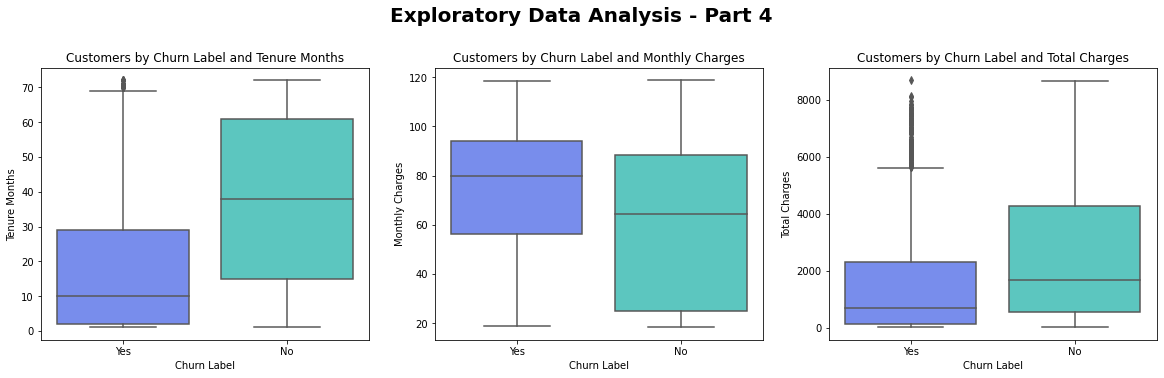

In [25]:
get_multiple_boxplots(churn_df, ['Tenure Months','Monthly Charges', 'Total Charges'], 'Churn Label')

### 3.3. Correlation analysis between continuous variables

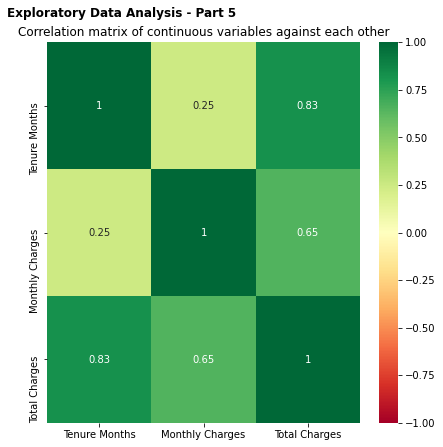

In [26]:
corr_df = churn_df[['Tenure Months', 'Monthly Charges', 'Total Charges']]
plt.figure(figsize=(7, 7))
sns.heatmap(corr_df.corr(), vmin=-1, vmax= 1, cmap="RdYlGn", annot=True)
plt.suptitle('Exploratory Data Analysis - Part 5', y=0.95, size=12, fontweight='bold', ha='right')
plt.title('Correlation matrix of continuous variables against each other', y=1, size=12, ha='center')
plt.show()

In [28]:
# Count all customers by city
cust_by_city_df = count_churn_by_col(churn_df, 'City').head(25)

# Count churn customers by city
churn_by_city_df = count_churn_by_col(churn_df[churn_df['Churn Label']=='Yes'], 'City').head(25)

# Count retained customers by city
retained_by_city_df = count_churn_by_col(churn_df[churn_df['Churn Label']=='No'], 'City').head(25)

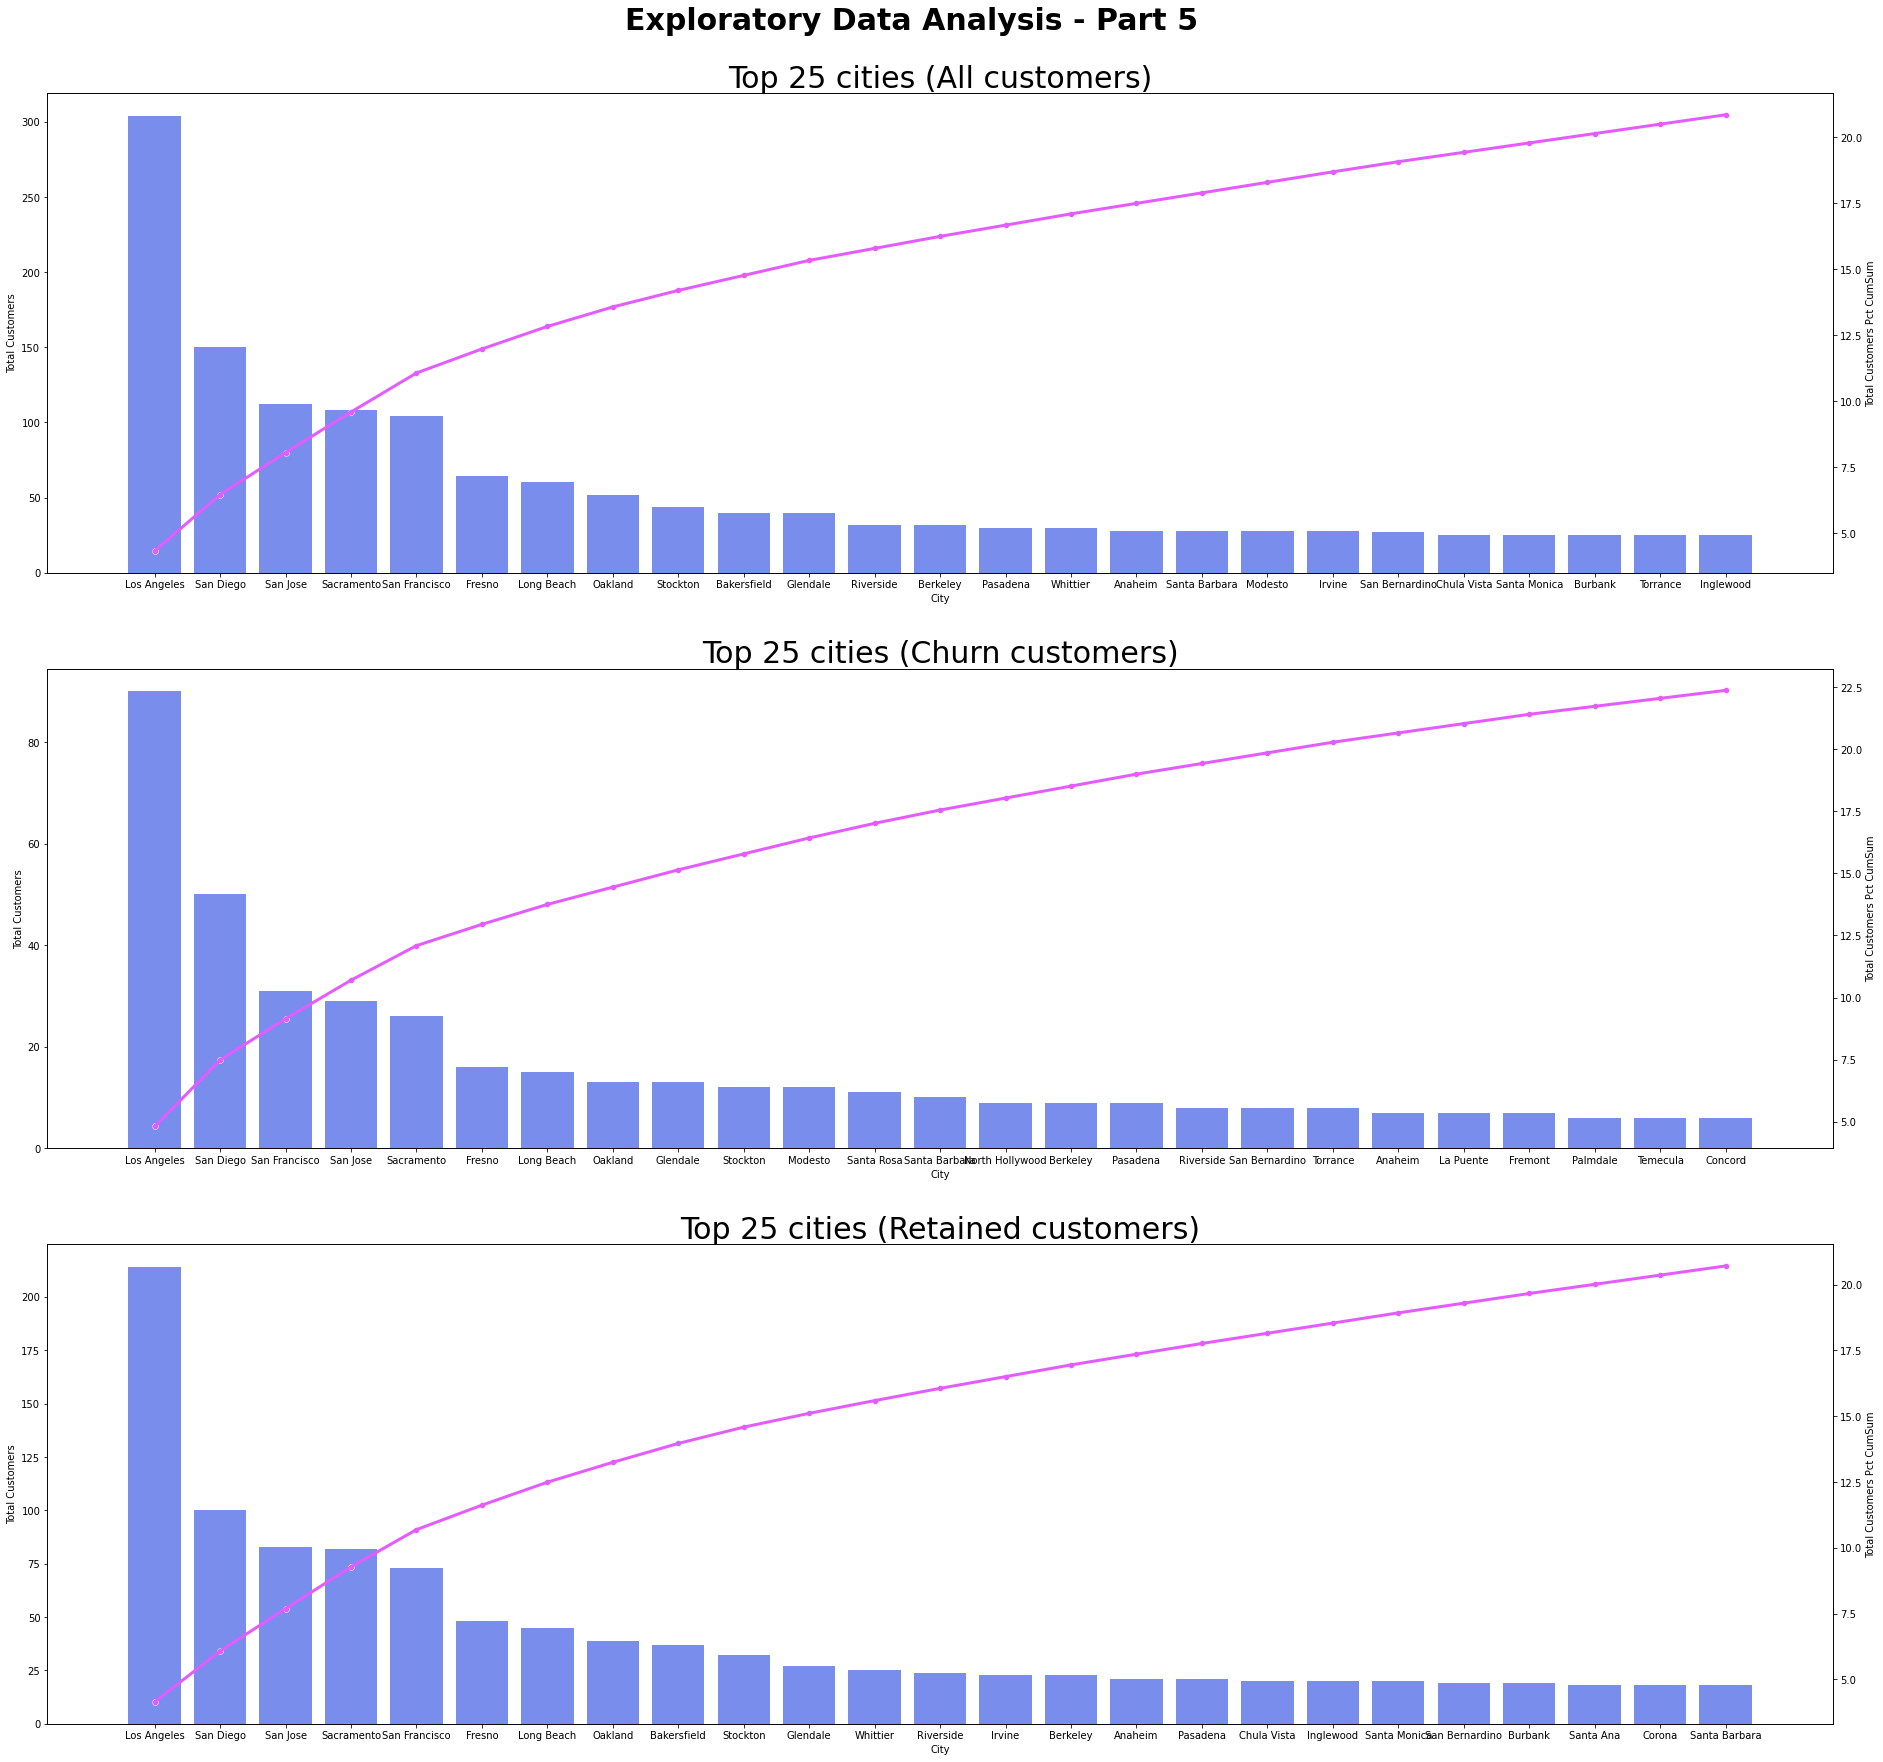

In [29]:
subplot_title_font_size = 30
colors = ['#6581FF','#4AD8CE','#E45BFF']

fig, ([ax1, ax2, ax3]) = plt.subplots(ncols=1, nrows=3, figsize=(32,30))
fig.suptitle(f'Exploratory Data Analysis - Part 5', fontsize=30, y=0.92, fontweight='bold')

# Chart 1: All customers by city
plt.subplot(3,1,1)
plt.title('Top 25 cities (All customers)', size=subplot_title_font_size)
sns.barplot(data=cust_by_city_df, x='City', y='Total Customers', color=colors[0])
plt.twinx()
sns.lineplot(data=cust_by_city_df, x='City', y='Total Customers Pct CumSum', color=colors[2], linewidth = 3)
sns.scatterplot(data=cust_by_city_df, x='City', y='Total Customers Pct CumSum', color=colors[2])

# Chart 2: Churn customers by city
plt.subplot(3,1,2)
plt.title('Top 25 cities (Churn customers)', size=subplot_title_font_size)
sns.barplot(data=churn_by_city_df, x='City', y='Total Customers', color=colors[0])
plt.twinx()
sns.lineplot(data=churn_by_city_df, x='City', y='Total Customers Pct CumSum', color=colors[2], linewidth = 3)
sns.scatterplot(data=churn_by_city_df, x='City', y='Total Customers Pct CumSum', color=colors[2])

# Chart 3: Retained customers by city
plt.subplot(3,1,3)
plt.title('Top 25 cities (Retained customers)', size=subplot_title_font_size)
sns.barplot(data=retained_by_city_df, x='City', y='Total Customers', color=colors[0])
plt.twinx()
sns.lineplot(data=retained_by_city_df, x='City', y='Total Customers Pct CumSum', color=colors[2], linewidth = 3)
sns.scatterplot(data=retained_by_city_df, x='City', y='Total Customers Pct CumSum', color=colors[2])

plt.show()

# 4. Feature selection

In [30]:
# Create a function to perform chi-square test
def chisquare_test(df, col_list, dependent_var):
    for col in col_list:
        # Create a contingency table
        crosstab_df = pd.crosstab(df[col], df[dependent_var], margins=True, margins_name='Total')

        # Declare input for the statistical test
        alpha = 0.05
        chi_square = 0
        rows = df[col].unique()
        columns = df[dependent_var].unique()
        
        # Perform test
        for i in columns:
            for j in rows:
                O = crosstab_df[i][j]
                E = crosstab_df[i]['Total'] * crosstab_df['Total'][j] / crosstab_df['Total']['Total']
                chi_square += (O-E)**2/E
        
        p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
        critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
        
        # Interpreting the result: The p-value approach
        if p_value <= alpha:
            print('There is' +  colored(' a relationship ','green',attrs=['bold']) + f'between {col} and {dependent_var}')
        else:
            print('There is' +  colored(' NO relationship ','red',attrs=['bold']) + f'between {col} and {dependent_var}')
        print(f'chi-square score: {chi_square}, critical_value: {critical_value}, p_value: {p_value}')
        
        print('\n')

In [31]:
# Declare list of columns to test
chisquare_col_list=['City','Gender','Senior Citizen','Partner','Dependents','Phone Service',
                    'Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection',
                    'Tech Support','Streaming TV','Streaming Movies','Contract','Paperless Billing','Payment Method']

# Perform chi-square test
chisquare_test(churn_df, chisquare_col_list, 'Churn Label')

There is a relationship between City and Churn Label
chi-square score: 1232.6880642095932, critical_value: 1207.246616230446, p_value: 0.01564773759080995


There is NO relationship between Gender and Churn Label
chi-square score: 0.5134128445822852, critical_value: 3.841458820694124, p_value: 0.473665182264535


There is a relationship between Senior Citizen and Churn Label
chi-square score: 159.36346482495168, critical_value: 3.841458820694124, p_value: 0.0


There is a relationship between Partner and Churn Label
chi-square score: 158.18187258531242, critical_value: 3.841458820694124, p_value: 0.0


There is a relationship between Dependents and Churn Label
chi-square score: 432.98573028640425, critical_value: 3.841458820694124, p_value: 0.0


There is NO relationship between Phone Service and Churn Label
chi-square score: 0.9611956938504398, critical_value: 3.841458820694124, p_value: 0.32688580734435513


There is a relationship between Multiple Lines and Churn Label
chi-square sc

#### Select features that show significant relationship with Churn Label

In [32]:
# Drop unnecessary columns
new_churn_df = churn_df.drop(columns={'CustomerID','Count','Country','State','Zip Code','Lat Long','Latitude','Longitude','Gender', 'Phone Service','Churn Reason'})

# 5. Feature engineering

In [33]:
# Encode categorical variables
new_churn_df=pd.get_dummies(new_churn_df,columns=['City','Senior Citizen','Partner','Dependents',
                                                  'Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection',
                                                  'Tech Support','Streaming TV','Streaming Movies','Contract','Paperless Billing','Payment Method','Churn Label'])

In [34]:
# Drop unnecessary columns
new_churn_df = new_churn_df.drop(columns={'Churn Label_No','Senior Citizen_No','Partner_No','Dependents_No'})

# 6. Model building

### 6A. Data splitting

In [35]:
y = new_churn_df['Churn Label_Yes']
X = new_churn_df.drop(columns={'Churn Label_Yes'})

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Describe the training and test set

In [36]:
x_train_records = X_train.shape[0]
y_train_records = y_train.shape[0]
x_test_records = X_test.shape[0]
y_test_records = y_test.shape[0]
print('Total records in each dataset')
print(f'x_train = {x_train_records} records')
print(f'y_train = {y_train_records} records')
print(f'x_test = {x_test_records} records')
print(f'y_test = {y_test_records} records')
print('\n')

y_train_df = pd.DataFrame()
y_train_df['Churn'] = y_train
print('Total churn customers in y_train')
print(y_train_df.value_counts())
print('\n')

y_test_df = pd.DataFrame()
y_test_df['Churn'] = y_test
print('Total churn customers in y_test')
print(y_test_df.value_counts())

Total records in each dataset
x_train = 5625 records
y_train = 5625 records
x_test = 1407 records
y_test = 1407 records


Total churn customers in y_train
Churn
0        4151
1        1474
dtype: int64


Total churn customers in y_test
Churn
0        1012
1         395
dtype: int64


### 6B. Data scaling on continuous variables

In [37]:
# Fit scaler into training set
column_list = ['Tenure Months', 'Monthly Charges', 'Total Charges']
X_train_to_scale = X_train[column_list]
X_test_to_scale = X_test[column_list]

column_transform = ColumnTransformer([('somename', StandardScaler(), column_list)], remainder='passthrough')
column_transform.fit(X_train_to_scale)

ColumnTransformer(remainder='passthrough',
                  transformers=[('somename', StandardScaler(),
                                 ['Tenure Months', 'Monthly Charges',
                                  'Total Charges'])])

In [38]:
# Scale training data
scaled_X_train_result = column_transform.transform(X_train_to_scale)
X_train_scaled = X_train.copy()
X_train_scaled[['Tenure Months', 'Monthly Charges', 'Total Charges']] = scaled_X_train_result

# Scale test data
scaled_X_test_result = column_transform.transform(X_test_to_scale)
X_test_scaled = X_test.copy()
X_test_scaled[['Tenure Months', 'Monthly Charges', 'Total Charges']] = column_transform.transform(X_test_to_scale)

### 6C . Model building

In [39]:
# Redeclare the training and test data after data scaling is performed
X_train = X_train_scaled
y_train = y_train.copy()
X_test = X_test_scaled
y_test = y_test.copy()

In [40]:
def get_confusion_matrix(classifier_name, y_test, y_pred):
    # Create confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    category = ['True Negative','False Positive','False Negative','True Positive']
    count = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    pct = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    cf_label = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(category, count, pct)]
    cf_label = np.asarray(cf_label).reshape(2,2)
    
    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred)*100,2)
    
    # Visualise confusion matrix
    fig, ax = plt.subplots(figsize=(5,4))
    plt.title(f'{classifier_name} - Accuracy: {accuracy}%', size=12)
    ax = sns.heatmap(cf_matrix, annot=cf_label, fmt='', cmap='RdYlGn')
    ax.tick_params(left=False, bottom=False) 
    plt.show()

In [41]:
def get_roc_curve(classifier_name, model, X_train, y_train, X_test, y_test):
    sns.set_palette(sns.color_palette('summer'))
    result = model.fit(X_train, y_train)
    metrics.plot_roc_curve(result, X_test, y_test)
    predict_prob = model.predict_proba(X_test)
    model_probs = predict_prob[:, 1]
    roc_auc = round(roc_auc_score(y_test, model_probs),2)
    print(colored(f'{classifier_name} ROC curve',attrs=['bold']))

In [42]:
def run_model(classifier_name, classifier, param_grid, scoring, X_train, y_train, X_test, y_test):
    start_time = time.time()
    pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                    ['classifier', classifier],
                                   ])
    stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator = pipeline,
                               param_grid = param_grid,
                               scoring=scoring,
                               cv = stratified_kfold,
                               n_jobs=-1,
                               refit=True)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.best_estimator_.predict(X_test)
    cpu_time = round(time.time() - start_time, 2)
    
    
    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred)*100,2)
    best_classifier = grid_search.best_estimator_

    print(colored(f'{classifier_name} Results',attrs=['bold']))
    print(f'CPU time: {cpu_time} seconds')
    print(f'Best classifier {best_classifier}')
    print('\n')
    print(colored(f'{classifier_name} Classification Report',attrs=['bold']))
    print(classification_report(y_test, y_pred))
    print('\n')
    print(colored(f'{classifier_name} Confusion Matrix',attrs=['bold']))
    
    # Create confusion matrix
    get_confusion_matrix(classifier_name, y_test, y_pred)
    
    # Create ROC Curve
    get_roc_curve(classifier_name, grid_search.fit(X_train, y_train), X_train, y_train, X_test, y_test)

### Model 1 - Logistics Regression

Logistic Regression Results
CPU time: 13.39 seconds
Best classifier Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ['classifier', LogisticRegression(C=0.1, random_state=42)]])


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1012
           1       0.59      0.74      0.66       395

    accuracy                           0.78      1407
   macro avg       0.74      0.77      0.75      1407
weighted avg       0.80      0.78      0.79      1407



Logistic Regression Confusion Matrix


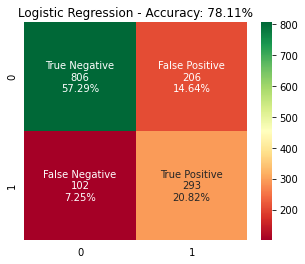

Logistic Regression ROC curve


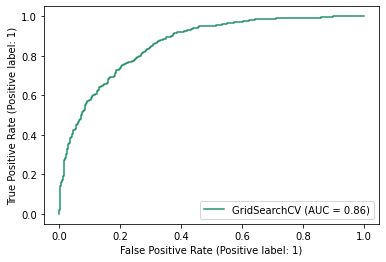

In [43]:
logreg_classifier = LogisticRegression(random_state=42)
logreg_param_grid = {'classifier__C':[0.001, 0.01, 0.1]}
scoring = 'roc_auc'
run_model('Logistic Regression', logreg_classifier, logreg_param_grid, scoring, X_train, y_train, X_test, y_test)

### Model 2 - Decision Tree

/Users/hutaminadya/Documents/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Decision Tree Results
CPU time: 119.11 seconds
Best classifier Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ['classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=4,
                                        random_state=42)]])


Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1012
           1       0.54      0.78      0.64       395

    accuracy                           0.75      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.75      0.76      1407



Decision Tree Confusion Matrix


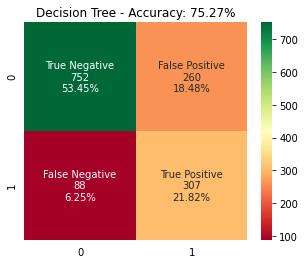

/Users/hutaminadya/Documents/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Decision Tree ROC curve


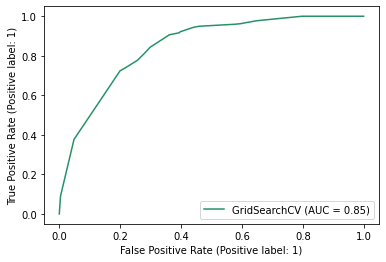

In [44]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_param_grid = {'classifier__min_samples_split' : [2,3,4,5],
                   'classifier__min_samples_leaf' : [2,3,4,5],
                   'classifier__max_depth' : [2,3,4,5]}
scoring = 'accuracy'
run_model('Decision Tree', dt_classifier, dt_param_grid, scoring, X_train, y_train, X_test, y_test)

### Model 3 - Random Forest

Random Forest Results
CPU time: 65.55 seconds
Best classifier Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ['classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        random_state=42)]])


Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1012
           1       0.54      0.79      0.64       395

    accuracy                           0.75      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.75      0.76      1407



Random Forest Confusion Matrix


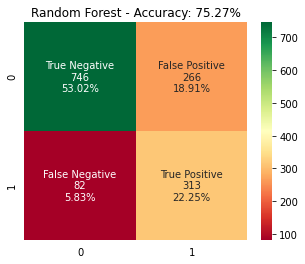

/Users/hutaminadya/Documents/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest ROC curve


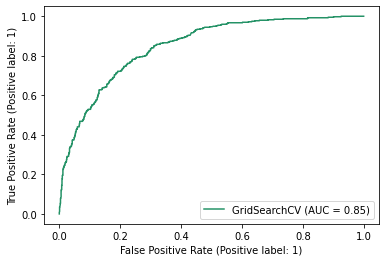

In [45]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_param_grid = {'classifier__min_samples_split' : [2,3,5],
                 'classifier__min_samples_leaf' : [2,3,5],
                 'classifier__max_depth' : [3,5,10]}
scoring = 'accuracy'
run_model('Random Forest', rf_classifier, rf_param_grid, scoring, X_train, y_train, X_test, y_test)

### Model 4 - Ada Boosting

Ada Boosting Results
CPU time: 34.98 seconds
Best classifier Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ['classifier',
                 AdaBoostClassifier(learning_rate=0.5, n_estimators=25,
                                    random_state=42)]])


Ada Boosting Classification Report
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1012
           1       0.54      0.82      0.65       395

    accuracy                           0.75      1407
   macro avg       0.73      0.77      0.73      1407
weighted avg       0.81      0.75      0.77      1407



Ada Boosting Confusion Matrix


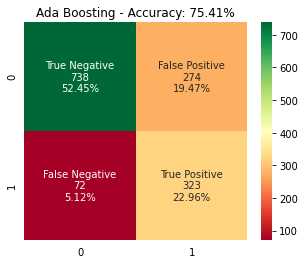

/Users/hutaminadya/Documents/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ada Boosting ROC curve


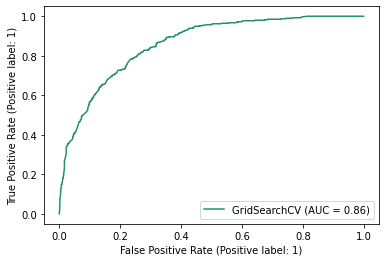

In [46]:
adaboost_classifier = AdaBoostClassifier(random_state=42)
adaboost_param_grid = {'classifier__n_estimators': [5, 10, 25],
                       'classifier__learning_rate': [0.05, 0.1, 0.25, 0.5]}
scoring = 'accuracy'
run_model('Ada Boosting', adaboost_classifier, adaboost_param_grid, scoring, X_train, y_train, X_test, y_test)

### Model 5 - Gradient Boosting

Gradient Boosting Results
CPU time: 58.57 seconds
Best classifier Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ['classifier',
                 GradientBoostingClassifier(learning_rate=0.2, n_estimators=50,
                                            random_state=42)]])


Gradient Boosting Classification Report
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1012
           1       0.57      0.76      0.65       395

    accuracy                           0.77      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.80      0.77      0.78      1407



Gradient Boosting Confusion Matrix


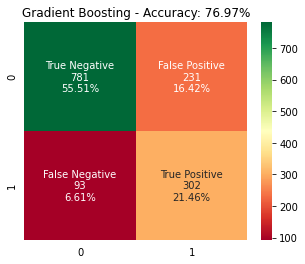

Gradient Boosting ROC curve


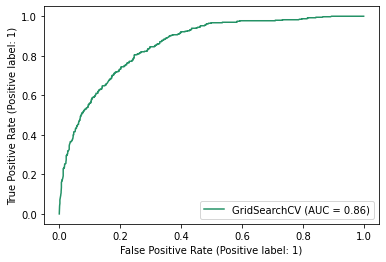

In [48]:
gboost_classifier = GradientBoostingClassifier(random_state=42)
gboost_param_grid = {'classifier__n_estimators': [10, 50],
    'classifier__learning_rate': [0.1, 0.2, 0.25, 0.5]}
scoring = 'accuracy'
run_model('Gradient Boosting', gboost_classifier, gboost_param_grid, scoring, X_train, y_train, X_test, y_test)